In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal
from scipy.io import wavfile
from scipy.interpolate import interp1d
from scipy.signal import spectrogram, istft, stft
import pywt
from pywt import wavedec, waverec

We read the image and we threshold it

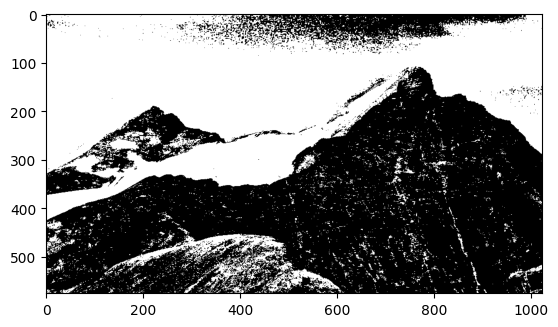

In [2]:
image = cv2.imread('../data/input_images/grande_sassiere.jpg')
imgray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(imgray, 90, 255, 0)
plt.imshow(thresh, cmap='gray')


## Analysis of a synth sound to understand the structure that I must aim for

We load the sound and we check it's temporal representation.

/tmp/ipykernel_4881/3713973936.py:3: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sample_rate, audio_data = wavfile.read(file_path)


Sample Rate: 48000 Hz
Duration: 12.679 seconds
Number of Channels: 1
Multi-channel audio not displayed in the plot.


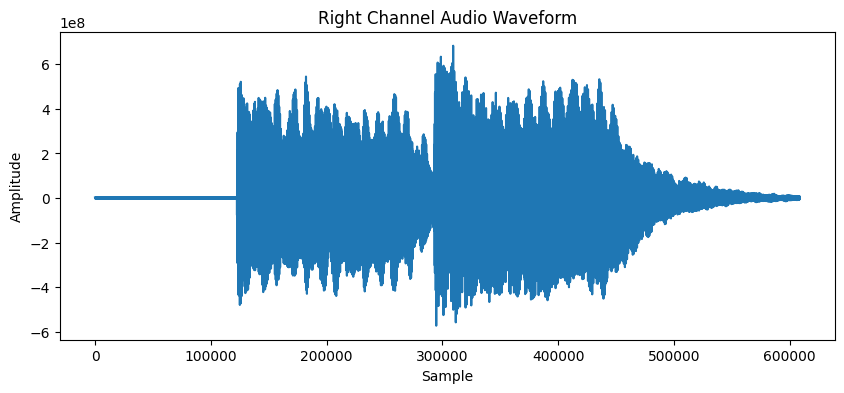

In [5]:
# Load the WAV file
file_path = "test_audio/1.wav"  
sample_rate, audio_data = wavfile.read(file_path)

# Get the audio duration in seconds
duration = len(audio_data) / sample_rate

# Print information about the audio
print(f"Sample Rate: {sample_rate} Hz")
print(f"Duration: {duration} seconds")
print(f"Number of Channels: {audio_data.shape[1] if len(audio_data.shape) > 1 else 1}")

# Plot the audio waveform (if mono audio)
if len(audio_data.shape) == 2:
    right_channel = audio_data[:, 1]  # Get the right channel
    plt.figure(figsize=(10, 4))
    plt.plot(right_channel)
    plt.title("Right Channel Audio Waveform")
    plt.xlabel("Sample")
    plt.ylabel("Amplitude")
    plt.show()
else:
    print("Multi-channel audio not displayed in the plot.")
      # Get the right channel
    plt.figure(figsize=(10, 4))
    plt.plot(audio_data)
    plt.title("Right Channel Audio Waveform")
    plt.xlabel("Sample")
    plt.ylabel("Amplitude")
    plt.show()

We then check it's fourier representation. It of course gives all the frequential information but no temporal information.

In [9]:
if len(audio_data.shape) == 2:
    mono_audio = np.mean(audio_data, axis=1)
else:
    mono_audio = audio_data

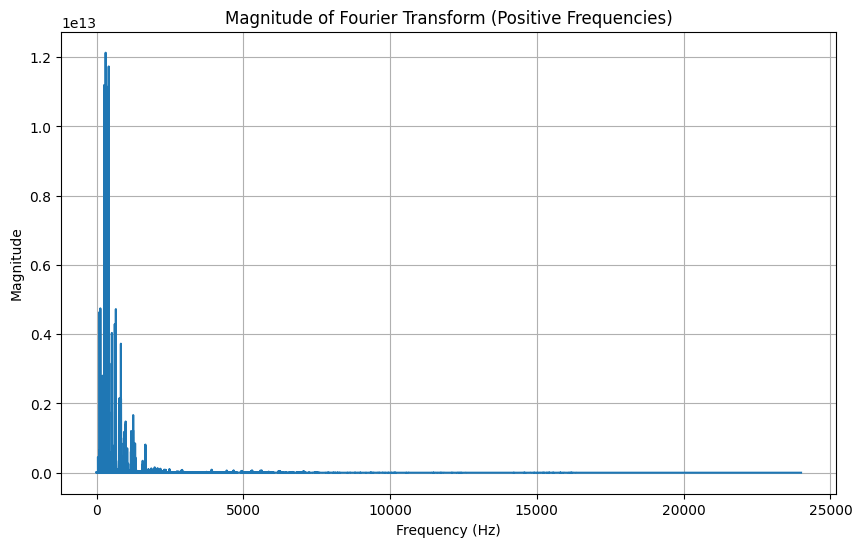

In [10]:
audio_fft = np.fft.fft(mono_audio)

audio_magnitude = np.abs(audio_fft)

n = len(audio_magnitude)
frequency_axis = np.fft.fftfreq(n, 1 / sample_rate)
positive_frequencies = frequency_axis[:n//2]
positive_magnitude = audio_magnitude[:n//2]

plt.figure(figsize=(10, 6))
plt.plot(positive_frequencies, positive_magnitude)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.title('Magnitude of Fourier Transform (Positive Frequencies)')
plt.grid(True)
plt.show()


We then perform stft to get a compromise between temporal information and frequential information.

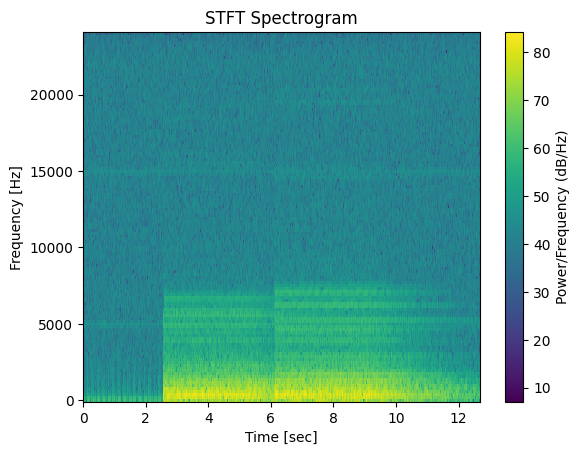

In [11]:
# Parameters for STFT
nperseg = 250  # Window size
noverlap = 50  # Overlap between windows

# Perform STFT
f, t, Zxx = stft(mono_audio, fs=sample_rate, nperseg=nperseg, noverlap=noverlap)

# Plot the spectrogram
plt.pcolormesh(t, f, 10 * np.log10(np.abs(Zxx)))
plt.title('STFT Spectrogram')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.colorbar(label='Power/Frequency (dB/Hz)')
plt.show()

We create some noisy version of the original signal as a comparison point.

In [12]:
noise_level = 1
noise = noise_level * np.random.normal(0, 1, len(mono_audio))
noisy_original_audio = mono_audio + noise

There is no visible difference in the temporal representation for all 3 signals.

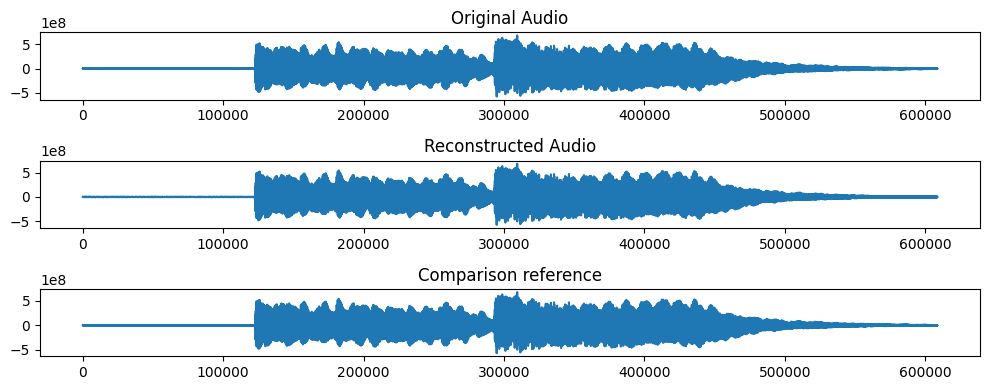

In [13]:
# Perform ISTFT
_, reconstructed_audio = istft(Zxx, fs=sample_rate, nperseg=nperseg, noverlap=noverlap)

# Plot the original and reconstructed signals
plt.figure(figsize=(10, 4))
plt.subplot(3, 1, 1)
plt.plot(mono_audio)
plt.title('Original Audio')

plt.subplot(3, 1, 2)
plt.plot(reconstructed_audio)
plt.title('Reconstructed Audio')

plt.subplot(3, 1, 3)
plt.plot(noisy_original_audio)
plt.title('Comparison reference')
plt.tight_layout()
plt.show()

The metric we use to see if the reconstructio is good is the signal to noise ratio which is the ratio of the power of signal divided by the reconstructio noise.

In [14]:
# Function to calculate Signal-to-Noise Ratio (SNR)
def calculate_snr(original, reconstructed):
    signal_power = np.sum(original**2)
    noise_power = np.sum((original - reconstructed)**2)
    snr = 10 * np.log10(signal_power / noise_power)
    return snr

the higher the singal to noise ratio, the better the reconstruction.

In [15]:

# Calculate the difference metric
difference_metric = calculate_snr(mono_audio, reconstructed_audio)
difference_metric_reference = calculate_snr(mono_audio, noisy_original_audio)

print(f"Difference Metric: {difference_metric}")
print(f"Difference Metric reference: {difference_metric_reference}")


# Write the reconstructed audio to a new WAV file
wavfile.write("witchhouse-pad_A_major_stft_reconstructed.wav", sample_rate, np.int16(reconstructed_audio))

ValueError: operands could not be broadcast together with shapes (608592,) (608600,) 

We now go a bit further and check the wavelet decomposition.

In [16]:
# Define the wavelet and decomposition level
wavelet_name = 'db12'  
level = 3

# Perform wavelet decomposition
coeffs = wavedec(mono_audio, wavelet_name, level=level)



# Reconstruct the audio from the scalogram
reconstructed_audio = waverec(coeffs, wavelet_name)

# Save the reconstructed audio to a WAV file
output_file = 'reconstructed_audio_from_scalogram.wav'
wavfile.write(output_file, sample_rate, reconstructed_audio.astype(np.int16))


In [17]:
# Calculate the difference metric
difference_metric = calculate_snr(mono_audio, reconstructed_audio)
difference_metric_reference = calculate_snr(mono_audio, noisy_original_audio)

print(f"Difference Metric : {difference_metric}")
print(f"Difference Metric reference: {difference_metric_reference}")

Difference Metric : nan
Difference Metric reference: nan


/tmp/ipykernel_4881/321265296.py:5: RuntimeWarning: invalid value encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)
